# Notes:


This notebook is an update of Pipe_LSS_Analysis.ipynb.

It analyses the results of the dDM/dz values created in Pipe_Creation_Plus_LSS_2.ipynb.

It analyses large scale structure content of pipes. It studies both the DM contributions, and the total cell number contributions.

It continues using the method described in Zhang+20: https://arxiv.org/abs/2011.14494

# Imports:

In [1]:
import os

import numpy as np
import illustris_python as il

from frb.dm import igm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd

from astropy import units as u
from numpy import random as rand
from astropy import constants as c
from matplotlib import pyplot as plt
from astropy.cosmology import Planck15 as cosmosource


# Load Theory

In [2]:
#get theory for next plot
theory_z_2 = np.array([0.0001,0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0,3.0,4.0])#,5.0])#,6.0,7.0,8.0, 9.0])
print('calculating average DMcosm')
cosm_theory_2=[igm.average_DM(i) for i in theory_z_2]
cosm_theory_2=[i.value for i in cosm_theory_2]
print('calculating average DMigm')
igm_theory_2=[igm.average_DMIGM(i) for i in theory_z_2]
igm_theory_2=[i.value for i in igm_theory_2]
print('calculating average DMhalo')
halo_theory_2=[igm.average_DMhalos(i) for i in theory_z_2]
halo_theory_2=[i.value for i in halo_theory_2]

calculating average DMcosm
calculating average DMigm
calculating average DMhalo


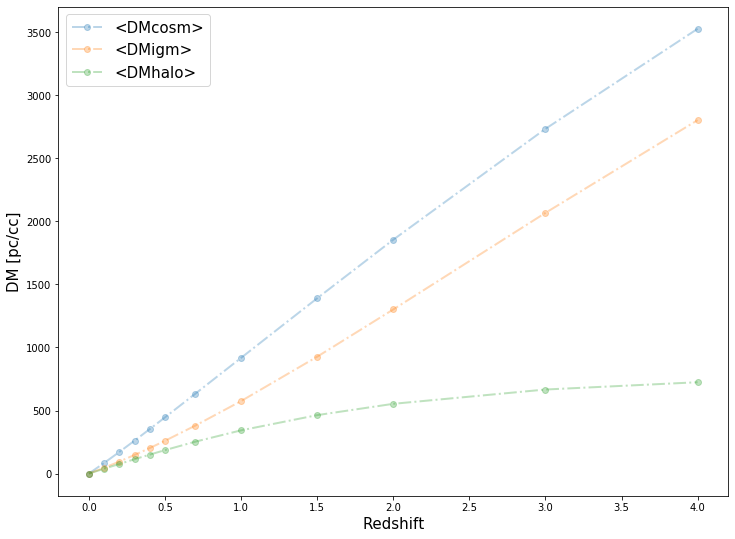

In [3]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

plt.legend(fontsize=15)
plt.show()


# Load pipe dDM/dz values

In [4]:
#############################
#Identify files to be loaded#
#############################
#simulation to load data for
sim_to_load = 'TNG50-3'


#all files
all_files = os.listdir('.')

#.npy files
npy_files = [i for i in all_files if '.npy' in i]

#ddmdz files
dDMdz_files = [i for i in npy_files if 'dDMdz_Output' in i]

#correct simulation
dDMdz_files = [i for i in npy_files if sim_to_load in i]

#list of snapshots wth data
snap_list = [int(i.split('_')[3]) for i in dDMdz_files]

#sort into ascending order
dDMdz_files = [x for _, x in sorted(zip(snap_list, dDMdz_files))]
snap_list.sort()

#reverse into descending order
dDMdz_files = dDMdz_files[::-1]
snap_list = snap_list[::-1]

#crop to redshift 5, because that is as far as the theory goes in FRB package.
#Note that after z=3 accuracy 'is not guaranteed'

dDMdz_files = dDMdz_files[0:12]
snap_list = snap_list[0:12]

#print to check
print(snap_list)
print(dDMdz_files)

[99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25, 21]
['Sim_TNG50-3_Snap_99_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_91_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_84_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_78_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_72_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_67_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_59_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_50_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_40_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_33_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_25_dDMdz_Output.npy', 'Sim_TNG50-3_Snap_21_dDMdz_Output.npy']


In [5]:
#######################################
#load the files into a data dictionary#
#######################################

#path to data
#basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)

dDMdz_dict = {} #initialise dictionary to hold dDMdz values
dDMdz_HaloDict = {} #initialise dictionary to hold the halo dDMdz portion
dDMdz_FilaDict = {} #initialise dictionary to hold the filament dDMdz portion
dDMdz_VoidDict = {} #initialise dictionary to hold the void dDMdz portion

halo_dict  = {} #initialise dictionary to hold number of halo cells
fila_dict  = {} #initialise dictionary to hold number of filament cells
void_dict  = {} #initialise dictionary to hold number of void cells

snap_redshifts = {} #initialise dictionary to hold redshifts of snapshots
snap_z_list = [] #initialise an array to hold these redshift values for plotting

for i in range(len(dDMdz_files)):#loop over files
    
    #load and extract dats
    snapshot = dDMdz_files[i].split('_')[3] #extract snapshot number
    
    vals = np.load(dDMdz_files[i],allow_pickle=True).tolist() #extract values from file
    
    dDMdz_dict[snapshot]=vals['dDMdz']*u.pc*u.cm**-3 #append dDMdz values to dictionary with snapshot number as key
    dDMdz_HaloDict[snapshot]=vals['dDMdzHalo']*u.pc*u.cm**-3 #do same for halo portion
    dDMdz_FilaDict[snapshot]=vals['dDMdzFilament']*u.pc*u.cm**-3 #do same for filament portion
    dDMdz_VoidDict[snapshot]=vals['dDMdzVoid']*u.pc*u.cm**-3 #do same for void portion

    halo_dict[snapshot]=np.array(vals['nHalo']) #append number of halo cells to dictionary with snapshot number as key
    fila_dict[snapshot]=np.array(vals['nFilament']) #append number of filament cells to dictionary with snapshot number as key
    void_dict[snapshot]=np.array(vals['nVoid']) #append number of void cells to dictionary with snapshot number as key
    header = il.groupcat.loadHeader(basePath,int(snapshot)) #extract simulation and snapshot header
    snap_redshifts[snapshot]=header['Redshift'] #get redshift at this snapshot
    snap_z_list.append(header['Redshift']) #append to array


print(snap_redshifts['99'])    
print('totals: {0}'.format(dDMdz_dict['99']))
print('sum of structures: {0}'.format(dDMdz_HaloDict['99']+dDMdz_FilaDict['99']+dDMdz_VoidDict['99']))
print(halo_dict['99'])
print(halo_dict['99']+fila_dict['99']+void_dict['99'])
print(len(snap_redshifts))

2.220446049250313e-16
totals: [236.38723393 667.6530167  362.57801059 ... 280.82881934 294.03971456
 449.72833848] pc / cm3
sum of structures: [236.38723393 667.6530167  362.57801059 ... 280.82881934 294.03971456
 449.72833848] pc / cm3
[0 0 0 ... 0 0 0]
[10000 10000 10000 ... 10000 10000 10000]
12


In [6]:
print(np.mean([1,2,3,4,5,6]))
print(np.mean([np.mean([1,2,3]),np.mean([4,5,6])]))
print(len(dDMdz_dict['99']))

3.5
3.5
5125


# Calculate total DM for a single line of sight,
# Calculate LSS DM values for this line of sight
# Also extract LSS cell details

In [7]:
#calculate DMIGM(z) for a single line of sight according to paper
x = snap_list


DMIGM     = [[0]*u.pc*u.cm**-3] #set initial condition to DM(z=0)=0
DMIGM_Halo = [[0]*u.pc*u.cm**-3] #set initial condition for only halo portion of DM
DMIGM_Fila = [[0]*u.pc*u.cm**-3] #set initial condition for only filament portion of DM
DMIGM_Void = [[0]*u.pc*u.cm**-3] #set initial condition for only void portion of DM

HaloCells = [0.] #initialise arrays to store the number of halo cells for the created LoS
FilaCells = [0.] #initialise arrays to store the number of filament cells for the created LoS
VoidCells = [0.] #initialise arrays to store the number of void cells for the created LoS

for i in range(len(x)-1): #loop over snapshots
    
    print(i)
    #get snapshot number for this snapshot
    snap_id = str(snap_list[i])
    #get snapshot number for next snapshot
    snap_id_ = str(snap_list[i+1])
    print(snap_id,snap_id_)
    #get this snapshot redshift
    snap_z = snap_redshifts[snap_id]
    #get next snapshot redshift
    snap_z_ = snap_redshifts[snap_id_]
    print(snap_z,snap_z_)
    
    #randomly select dDM/dz and LSS cell values for this redshift
    
    #select the pipe
    rand_idx = np.random.choice(np.arange(len(dDMdz_dict[snap_id])))
    print(rand_idx)
    #get the dDMdz values
    rand_dDMdz = dDMdz_dict[snap_id][rand_idx]
    rand_dDMdz_Halo = dDMdz_HaloDict[snap_id][rand_idx]
    rand_dDMdz_Fila = dDMdz_FilaDict[snap_id][rand_idx]
    rand_dDMdz_Void = dDMdz_VoidDict[snap_id][rand_idx]
    #get the cell values
    rand_nHalo = halo_dict[snap_id][rand_idx]
    rand_nFila = fila_dict[snap_id][rand_idx]
    rand_nVoid = void_dict[snap_id][rand_idx]
    print('test',rand_dDMdz,rand_dDMdz_Halo+rand_dDMdz_Fila+rand_dDMdz_Void)
    
    #randomly select dDM/dz and LSS cell values for next redshift
    
    #select the pipe
    rand_idx_ = np.random.choice(np.arange(len(dDMdz_dict[snap_id_])))   
    #get the dDMdz values
    rand_dDMdz_ = dDMdz_dict[snap_id_][rand_idx_]    
    rand_dDMdz_Halo_ = dDMdz_HaloDict[snap_id_][rand_idx_]
    rand_dDMdz_Fila_ = dDMdz_FilaDict[snap_id_][rand_idx_]
    rand_dDMdz_Void_ = dDMdz_VoidDict[snap_id_][rand_idx_]
    #get the cell values
    rand_nHalo_ = halo_dict[snap_id_][rand_idx_]
    rand_nFila_ = fila_dict[snap_id_][rand_idx_]
    rand_nVoid_ = void_dict[snap_id_][rand_idx_]
    print('test',rand_dDMdz_,rand_dDMdz_Halo_+rand_dDMdz_Fila_+rand_dDMdz_Void_)
    
    #create the DM values
    nextDM     = DMIGM[i] + ((0.5*(rand_dDMdz+rand_dDMdz_)) * (snap_z_ -  snap_z))
    nextHaloDM = DMIGM_Halo[i] + ((0.5*(rand_dDMdz_Halo+rand_dDMdz_Halo_)) * (snap_z_ -  snap_z))
    nextFilaDM = DMIGM_Fila[i] + ((0.5*(rand_dDMdz_Fila+rand_dDMdz_Fila_)) * (snap_z_ -  snap_z))
    nextVoidDM = DMIGM_Void[i] + ((0.5*(rand_dDMdz_Void+rand_dDMdz_Void_)) * (snap_z_ -  snap_z))
    
    #create the number of LSS cell value by averaging those of the two chosen pipes
    nextHalo = (0.5*(rand_nHalo+rand_nHalo_))
    nextFila = (0.5*(rand_nFila+rand_nFila_))
    nextVoid = (0.5*(rand_nVoid+rand_nVoid_))
    
    DMIGM.append(nextDM)
    DMIGM_Halo.append(nextHaloDM)
    DMIGM_Fila.append(nextFilaDM)
    DMIGM_Void.append(nextVoidDM)
    
    HaloCells.append(nextHalo)
    FilaCells.append(nextFila)
    VoidCells.append(nextVoid)

    
#create the fractions of LSS cells at each point
fraction_Halo = np.array(HaloCells)/(np.array(HaloCells)+np.array(FilaCells)+np.array(VoidCells))
fraction_Fila = np.array(FilaCells)/(np.array(HaloCells)+np.array(FilaCells)+np.array(VoidCells))
fraction_Void = np.array(VoidCells)/(np.array(HaloCells)+np.array(FilaCells)+np.array(VoidCells))

#onvert to numpy arrays
DMIGM = np.array(DMIGM)
DMIGM_Halo = np.array(DMIGM_Halo)
DMIGM_Fila = np.array(DMIGM_Fila)
DMIGM_Void = np.array(DMIGM_Void)

print(' tests')
print(len(x),len(DMIGM))
print(HaloCells)
print('DM_tests')
print(DMIGM,DMIGM_Halo+DMIGM_Fila+DMIGM_Void)
print('fracion tests')
print(fraction_Halo)
print(fraction_Fila)
print(fraction_Void)
print(fraction_Halo+fraction_Fila+fraction_Void)

0
99 91
2.220446049250313e-16 0.09940180263022191
4458
test 689.7835172534583 pc / cm3 689.7835172534585 pc / cm3
test 180.37607503549316 pc / cm3 180.3760750354931 pc / cm3
1
91 84
0.09940180263022191 0.19728418237600986
566
test 1046.2036279939543 pc / cm3 1046.2036279939546 pc / cm3
test 439.7835650962228 pc / cm3 439.7835650962228 pc / cm3
2
84 78
0.19728418237600986 0.2977176845174465
2872
test 478.41931671875733 pc / cm3 478.41931671875733 pc / cm3
test 600.7038371949205 pc / cm3 600.7038371949204 pc / cm3
3
78 72
0.2977176845174465 0.3999269646135635
2208
test 389.07893661320804 pc / cm3 389.07893661320816 pc / cm3
test 10051.66161042193 pc / cm3 10051.661610421928 pc / cm3
4
72 67
0.3999269646135635 0.5030475232448832
2133
test 506.5631721563793 pc / cm3 506.5631721563792 pc / cm3
test 453.0437291125452 pc / cm3 453.0437291125453 pc / cm3
5
67 59
0.5030475232448832 0.7001063537185233
799
test 1630.3656551563668 pc / cm3 1630.3656551563665 pc / cm3
test 349.18148548917765 pc / c

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


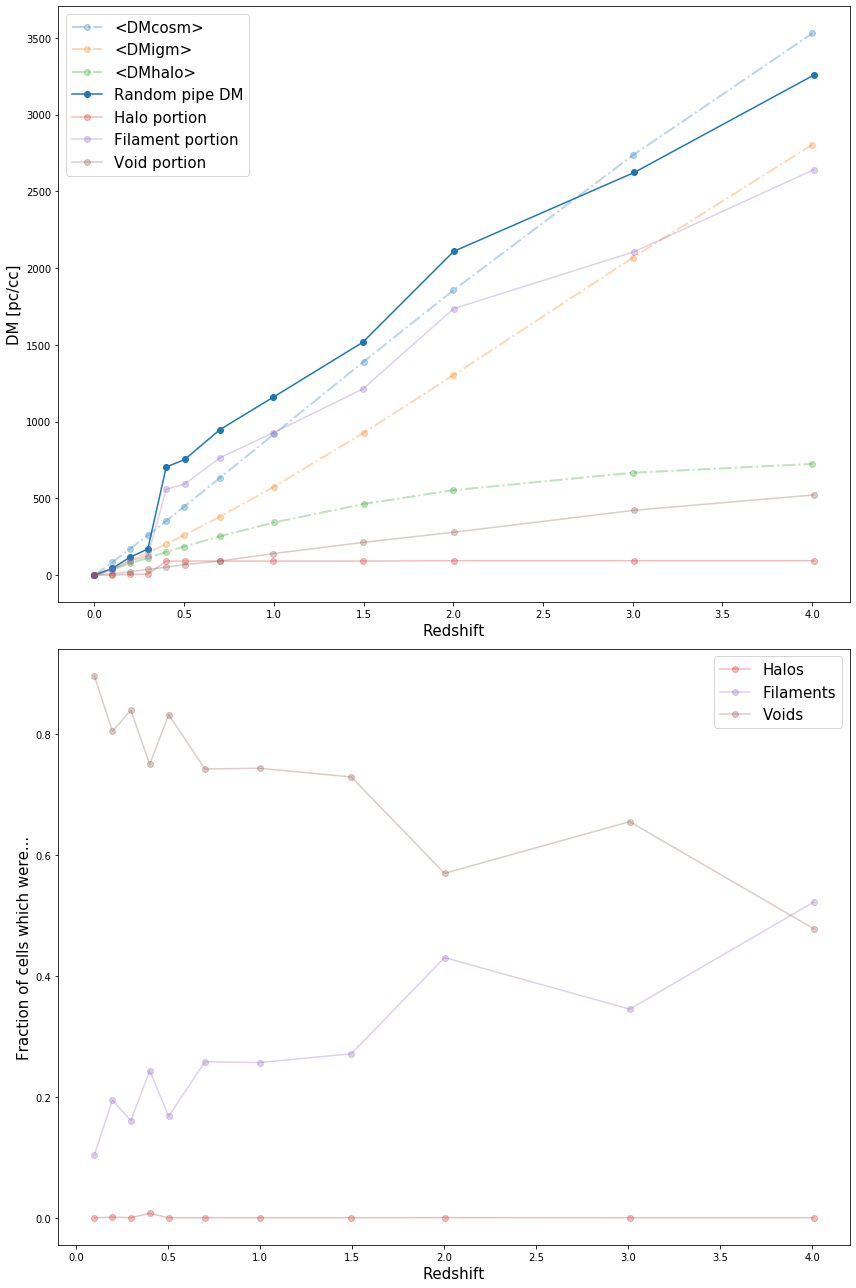

In [8]:
fig = plt.figure(figsize=(12,18))
ax = fig.add_subplot(211)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax.plot(snap_z_list,DMIGM,marker='o',label='Random pipe DM')
ax.plot(snap_z_list,DMIGM_Halo,marker='o',color='C3',alpha=0.3,label='Halo portion')
ax.plot(snap_z_list,DMIGM_Fila,marker='o',color='C4',alpha=0.3,label='Filament portion')
ax.plot(snap_z_list,DMIGM_Void,marker='o',color='C5',alpha=0.3,label='Void portion')
plt.legend(fontsize=15)

ax2 = fig.add_subplot(212)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('Fraction of cells which were...',fontsize=15)

ax2.plot(snap_z_list,fraction_Halo,marker='o',color='C3',alpha=0.3,label='Halos')
ax2.plot(snap_z_list,fraction_Fila,marker='o',color='C4',alpha=0.3,label='Filaments')
ax2.plot(snap_z_list,fraction_Void,marker='o',color='C5',alpha=0.3,label='Voids')

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Single_LoS_Analysis.png'.format(sim_to_load),format='png')
plt.show()


# Calculate DM for many lines of sight

## figuring out array version

In [9]:
print(snap_list)

nlos = 2 #number of lines of sight

################################################
#original version from Pipe_Analysis_Test.ipynb#
################################################

test_dDMdz_arr = np.array([np.random.choice(dDMdz_dict[str(snap_id)],size=nlos) for snap_id in snap_list])*u.pc*u.cm**-3
test_z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

print('original:',test_dDMdz_arr,test_z_arr)

###################################################
#New version which allows LSS data to be extracted#
###################################################

test_idx_arr = np.array([np.random.choice(np.arange(len(dDMdz_dict[str(snap_id)])),size=nlos) for snap_id in snap_list])
print('test indices array = ',test_idx_arr)
test_idxDM_arr = np.array([dDMdz_dict[str(snap_list[snap])][test_idx_arr][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
print('test indices dm array = ',test_idxDM_arr)
test_idxHalo_arr = np.array([halo_dict[str(snap_list[snap])][test_idx_arr][snap] for snap in range(len(snap_list))])
print('test indices halo array = ',test_idxHalo_arr)

##single line of sight of multiple
#print('\ntesting for a single los from list of sightlines\n')
#
#print('all data: ',test_dDMdz_arr[:])
#print('one los dDM vals: ',test_dDMdz_arr[:,0])
#print('all but last of these: ',test_dDMdz_arr[:,0][0:-1])
#print('all but first of these: ',test_dDMdz_arr[:,0][1:])
#print('average of these: ', 0.5*(test_dDMdz_arr[:,0][0:-1]+test_dDMdz_arr[:,0][1:]))
#print('corresponding all redshifts: ',test_z_arr[:])
#print('corresponding all but first of these: ',test_z_arr[:][1:])
#print('corresponding all but last of these: ',test_z_arr[:][0:-1])
#print('corresponding difference between these: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1]))
#print('performing calculation: ', (0.5*(test_dDMdz_arr[:,0][0:-1]+test_dDMdz_arr[:,0][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1]))

#all lines of sight
#print('\ntesting for all los from list of sightlines\n')

#print('all data: ',test_dDMdz_arr[:])
#print('all los dDM vals: ',test_dDMdz_arr[:,:])
#print('all but last of these: ',test_dDMdz_arr[:,:][0:-1])
#print('all but first of these: ',test_dDMdz_arr[:,:][1:])
#print('average of these: ', 0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))
#print('corresponding all redshifts: ',test_z_arr[:])
#print('corresponding all but first of these: ',test_z_arr[:][1:])
#print('corresponding all but last of these: ',test_z_arr[:][0:-1])
#print('corresponding difference between these: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1]))
#print('giving this an extra axis: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None])
#print('performing calculation: ', (0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None])
#test_DM_arr = (0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None]
#test_DM_arr = np.insert(test_DM_arr,0,np.zeros(nlos),axis=0)
#print('adding z=0 values to beginning: ',test_DM_arr)
#test_cDM_arr = np.cumsum(test_DM_arr,axis=0)
#print('getting cDM array: ',test_cDM_arr)

[99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25, 21]
original: [[ 912.37646314  367.84265038]
 [ 310.35495396  471.2558828 ]
 [ 400.24807667  496.19286376]
 [ 484.48919723 1071.03208048]
 [ 582.92873721  403.31118231]
 [ 626.64123682  659.01088976]
 [ 492.55700835  391.54484455]
 [ 603.98650985  419.82450968]
 [1254.05414354  424.89786157]
 [ 806.01921567 1254.03637988]
 [ 740.92322012  795.81401158]
 [ 576.51362481 1493.15892507]] pc / cm3 [2.22044605e-16 9.94018026e-02 1.97284182e-01 2.97717685e-01
 3.99926965e-01 5.03047523e-01 7.00106354e-01 9.97294226e-01
 1.49551217e+00 2.00202814e+00 3.00813107e+00 4.00794511e+00]
test indices array =  [[  68 4323]
 [ 828 1667]
 [1021 4039]
 [4703 2819]
 [4834 1438]
 [4951 4689]
 [2042 4793]
 [ 395 2688]
 [3965 4982]
 [ 580 2638]
 [2546 1049]
 [3781 1743]]
test indices dm array =  [[ 1117.73672823   232.69885443]
 [  214.81789101   272.5196191 ]
 [  710.36173187   246.3373311 ]
 [  278.39058919   194.98131946]
 [ 1132.10800416 10283.62453233]
 [  64

In [10]:
#test to see if you can extract anything indexes from an array with a mask
myarr = np.array([100,9,5,64,7,76520,0,999,666,69,1])
mytestidx = [0,8,6,5]
print(myarr)
print(myarr[mytestidx])


#test to see if new tests worked
#print(dDMdz_dict['99'][1507])
#print(dDMdz_dict['99'][3176])
#print(dDMdz_dict['91'][2253])
#print(dDMdz_dict['91'][3872])
#print(dDMdz_dict['40'][2907])
#print(dDMdz_dict['40'][1611])
#print(halo_dict['67'][3697],halo_dict['67'][5055])
#print(halo_dict['59'][3392],halo_dict['59'][418])
#print(halo_dict['50'][4092],halo_dict['50'][2469])

[  100     9     5    64     7 76520     0   999   666    69     1]
[  100   666     0 76520]


## creating array of cDM for many sightlines

In [11]:
nlos = 10000000 #number of lines of sight

################################################
#create an array of randomly drawn dDMdz values#
################################################

#old version
#dDMdz_arr = np.array([np.random.choice(dDMdz_dict[str(snap_id)],size=nlos) for snap_id in snap_list])*u.pc*u.cm**-3

#new version

#array of randomly generated indices to select pipes from each snapshot
idx_arr = np.array([np.random.choice(np.arange(len(dDMdz_dict[str(snap_id)])),size=nlos) for snap_id in snap_list])
#the dDMdz values of these pipes
dDMdz_arr = np.array([dDMdz_dict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
#the halo, filament and void values of these pipes
dDMdz_HaloArr = np.array([dDMdz_HaloDict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_FilaArr = np.array([dDMdz_FilaDict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_VoidArr = np.array([dDMdz_VoidDict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
print('check: the difference between the totals and the sum of the structures should be zero')
print(np.sum(dDMdz_arr - (dDMdz_HaloArr+dDMdz_FilaArr+dDMdz_VoidArr)))

#############################
#also extract arrays for LSS#
#############################

#the number of halo cells which made this pipe
los_Halo_arr = np.array([halo_dict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])
#the number of filament cells which made this pipe
los_Fila_arr = np.array([fila_dict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])
#the number of void cells which made this pipe
los_Void_arr = np.array([void_dict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])

###########################
#create array of redshifts#
###########################

z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

####################################################
#perform the calculation to get DM at each redshift#
####################################################

DM_arr = (0.5*(dDMdz_arr[:,:][0:-1]+dDMdz_arr[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #total
DM_HaloArr = (0.5*(dDMdz_HaloArr[:,:][0:-1]+dDMdz_HaloArr[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #halos
DM_FilaArr = (0.5*(dDMdz_FilaArr[:,:][0:-1]+dDMdz_FilaArr[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #filaments
DM_VoidArr = (0.5*(dDMdz_VoidArr[:,:][0:-1]+dDMdz_VoidArr[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #voids


#print(DM_arr.shape)
######################################################################
#perform the calculation to get the average LSS data at each redshift#
######################################################################

av_Hal_arr = (0.5*(los_Halo_arr[:,:][0:-1]+los_Halo_arr[:,:][1:]))
av_Fil_arr = (0.5*(los_Fila_arr[:,:][0:-1]+los_Fila_arr[:,:][1:]))
av_Voi_arr = (0.5*(los_Void_arr[:,:][0:-1]+los_Void_arr[:,:][1:]))
#print(av_Hal_arr.shape)
print('check: the sum of these should be 10,000 for every pipe at every z\n',
      av_Hal_arr+av_Fil_arr+av_Voi_arr,
      np.mean(av_Hal_arr+av_Fil_arr+av_Voi_arr))

##############################################################################
#perform the calculation to turn these into fractions of LSS at each redshift#
##############################################################################

frac_Hal_arr = av_Hal_arr/(av_Hal_arr+av_Fil_arr+av_Voi_arr)
frac_Fil_arr = av_Fil_arr/(av_Hal_arr+av_Fil_arr+av_Voi_arr)
frac_Voi_arr = av_Voi_arr/(av_Hal_arr+av_Fil_arr+av_Voi_arr)
#print(frac_Hal_arr.shape)
print('check: the sum of these should be 1 for every pipe at every z\n',
      frac_Hal_arr+frac_Fil_arr+frac_Voi_arr,
      np.sum((frac_Hal_arr+frac_Fil_arr+frac_Voi_arr),axis=0))

#######################################
#add the initial condition of DM=0@z=0#
#######################################

#DMs
DM_arr     = np.insert(DM_arr,0,np.zeros(nlos),axis=0)
Hal_DM_arr = np.insert(DM_HaloArr,0,np.zeros(nlos),axis=0)
Fil_DM_arr = np.insert(DM_FilaArr,0,np.zeros(nlos),axis=0)
Voi_DM_arr = np.insert(DM_VoidArr,0,np.zeros(nlos),axis=0)


frac_Hal_arr = np.insert(frac_Hal_arr,0,np.zeros(nlos),axis=0)
frac_Fil_arr = np.insert(frac_Fil_arr,0,np.zeros(nlos),axis=0)
frac_Voi_arr = np.insert(frac_Voi_arr,0,np.zeros(nlos),axis=0)

#################################################################
#calculate arrays for the DM from each LSS type at each redshift#
#################################################################
#Hal_DM_arr = DM_arr * frac_Hal_arr
#Fil_DM_arr = DM_arr * frac_Fil_arr
#Voi_DM_arr = DM_arr * frac_Voi_arr


#print(DM_arr.shape)
#print(frac_Fil_arr.shape)

print('check: the DM_arr / the sum of the structures should be 1',DM_arr/(Hal_DM_arr+Fil_DM_arr+Voi_DM_arr))

##############################################################
#perform the cumulative sum to get the cDM for each light ray#
##############################################################
cDM_arr = np.cumsum(DM_arr,axis=0) #total
Hal_cDM_arr = np.cumsum(Hal_DM_arr,axis=0) #halo
Fil_cDM_arr = np.cumsum(Fil_DM_arr,axis=0) #filament
Voi_cDM_arr = np.cumsum(Voi_DM_arr,axis=0) #void

print('check: the cDM_arr / the sum of the structures should be 1',cDM_arr/(Hal_cDM_arr+Fil_cDM_arr+Voi_cDM_arr))


#print(DM_arr)
#print(cDM_arr)
print(cDM_arr.shape)

check: the difference between the totals and the sum of the structures should be zero
-1.021990385652316e-07 pc / cm3
check: the sum of these should be 10,000 for every pipe at every z
 [[10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 ...
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]] 10000.0
check: the sum of these should be 1 for every pipe at every z
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]] [11. 11. 11. ... 11. 11. 11.]


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


check: the DM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
check: the cDM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
(12, 10000000)


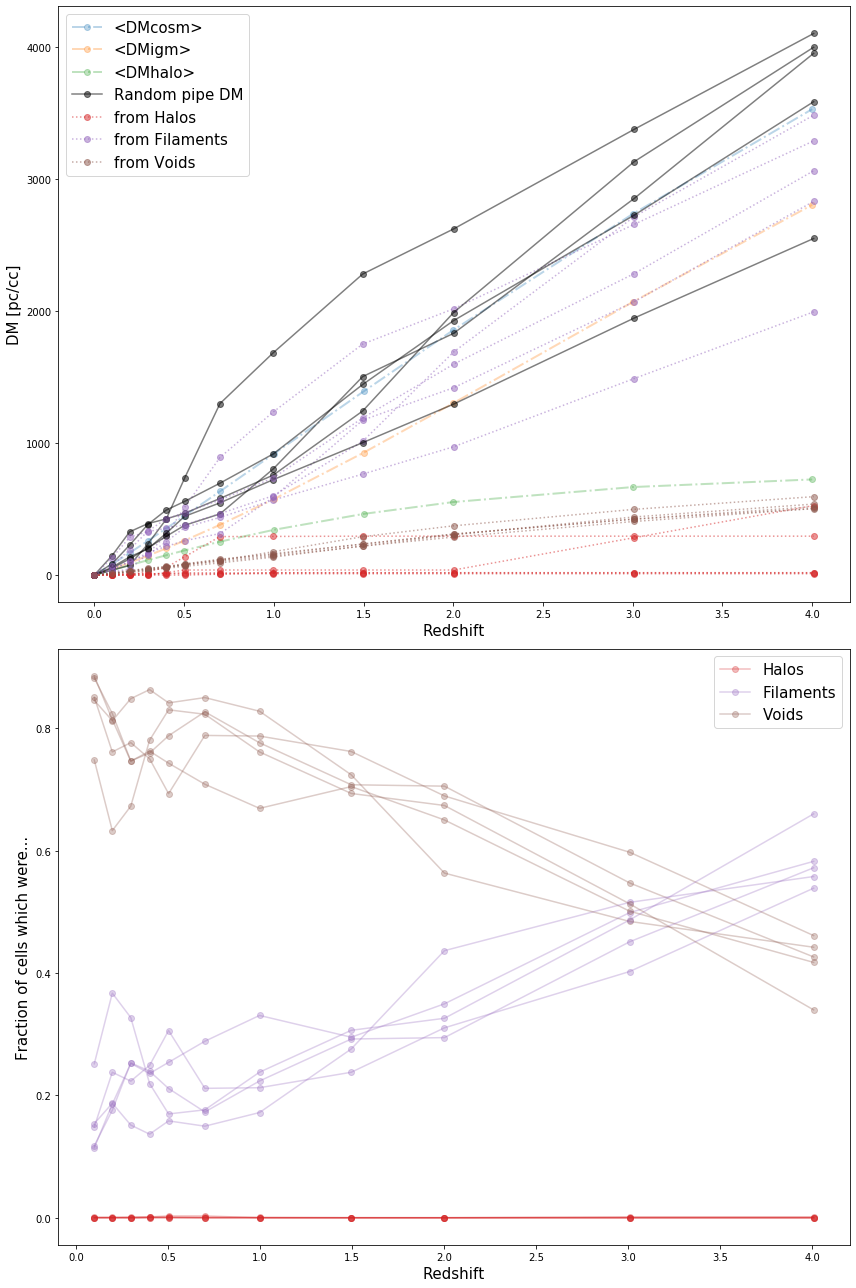

In [12]:
fig = plt.figure(figsize=(12,18))
ax = fig.add_subplot(211)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

for i in range(5):
    if i==0:
        ax.plot(snap_z_list,cDM_arr[:,i],marker='o',color='k',alpha=0.5,label='Random pipe DM')
        ax.plot(snap_z_list,Hal_cDM_arr[:,i],marker='o',ls=':',color='C3',alpha=0.5,label='from Halos')
        ax.plot(snap_z_list,Fil_cDM_arr[:,i],marker='o',ls=':',color='C4',alpha=0.5,label='from Filaments')
        ax.plot(snap_z_list,Voi_cDM_arr[:,i],marker='o',ls=':',color='C5',alpha=0.5,label='from Voids')

    else:
        ax.plot(snap_z_list,cDM_arr[:,i],marker='o',color='k',alpha=0.5)
        ax.plot(snap_z_list,Hal_cDM_arr[:,i],marker='o',ls=':',color='C3',alpha=0.5)
        ax.plot(snap_z_list,Fil_cDM_arr[:,i],marker='o',ls=':',color='C4',alpha=0.5)
        ax.plot(snap_z_list,Voi_cDM_arr[:,i],marker='o',ls=':',color='C5',alpha=0.5)
plt.legend(fontsize=15)

        
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('Fraction of cells which were...',fontsize=15)

for i in range(5):
    if i==0:
        ax2.plot(snap_z_list[1:],frac_Hal_arr[:,i][1:],marker='o',alpha=0.3,color='C3',label='Halos')
        ax2.plot(snap_z_list[1:],frac_Fil_arr[:,i][1:],marker='o',alpha=0.3,color='C4',label='Filaments')
        ax2.plot(snap_z_list[1:],frac_Voi_arr[:,i][1:],marker='o',alpha=0.3,color='C5',label='Voids')
    else:
        ax2.plot(snap_z_list[1:],frac_Hal_arr[:,i][1:],marker='o',alpha=0.3,color='C3')
        ax2.plot(snap_z_list[1:],frac_Fil_arr[:,i][1:],marker='o',alpha=0.3,color='C4')
        ax2.plot(snap_z_list[1:],frac_Voi_arr[:,i][1:],marker='o',alpha=0.3,color='C5')

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Analysis.png'.format(sim_to_load),formaat='png')
plt.show()

## get statistics

In [13]:
#totals
mean_cDM_arr = np.mean(cDM_arr,axis=1) #mean
medi_cDM_arr = np.median(cDM_arr,axis=1) #median
stdv_cDM_arr = np.std(cDM_arr,axis=1) #standard deviation

#halos
mean_Hal_cDM_arr = np.mean(Hal_cDM_arr,axis=1) #mean
medi_Hal_cDM_arr = np.median(Hal_cDM_arr,axis=1) #median
stdv_Hal_cDM_arr = np.std(Hal_cDM_arr,axis=1) #standard deviation

mean_frac_Hal_arr = np.mean(frac_Hal_arr,axis=1) #mean
medi_frac_Hal_arr = np.median(frac_Hal_arr,axis=1) #median
stdv_frac_Hal_arr = np.std(frac_Hal_arr,axis=1) #standard deviation

#filaments
mean_Fil_cDM_arr = np.mean(Fil_cDM_arr,axis=1) #mean
medi_Fil_cDM_arr = np.median(Fil_cDM_arr,axis=1) #median
stdv_Fil_cDM_arr = np.std(Fil_cDM_arr,axis=1) #standard deviation

mean_frac_Fil_arr = np.mean(frac_Fil_arr,axis=1) #mean
medi_frac_Fil_arr = np.median(frac_Fil_arr,axis=1) #median
stdv_frac_Fil_arr = np.std(frac_Fil_arr,axis=1) #standard deviation

#voids
mean_Voi_cDM_arr = np.mean(Voi_cDM_arr,axis=1) #mean
medi_Voi_cDM_arr = np.median(Voi_cDM_arr,axis=1) #median
stdv_Voi_cDM_arr = np.std(Voi_cDM_arr,axis=1) #standard deviation

mean_frac_Voi_arr = np.mean(frac_Voi_arr,axis=1) #mean
medi_frac_Voi_arr = np.median(frac_Voi_arr,axis=1) #median
stdv_frac_Voi_arr = np.std(frac_Voi_arr,axis=1) #standard deviation

print('Mean cDM: ',mean_cDM_arr)
print('Median cDM: ',medi_cDM_arr)
print('Standard deviation of cDM: ',stdv_cDM_arr)

Mean cDM:  [   0.           94.54187398  192.25471438  292.87342509  396.15835483
  503.2871693   710.71770234 1017.12728559 1510.10490209 1991.45147051
 2880.54833921 3660.4965925 ] pc / cm3
Median cDM:  [   0.           60.04724709  132.38422967  216.52927397  308.43359655
  404.53365316  588.6266691   864.51171899 1315.14249779 1771.49608323
 2623.87481854 3391.47330395] pc / cm3
Standard deviation of cDM:  [   0.          147.61024875  272.03834511  328.47663195  367.95902228
  403.30861739  487.26461795  610.61593273  772.4785831   887.82828724
 1058.59749726 1152.35180614] pc / cm3


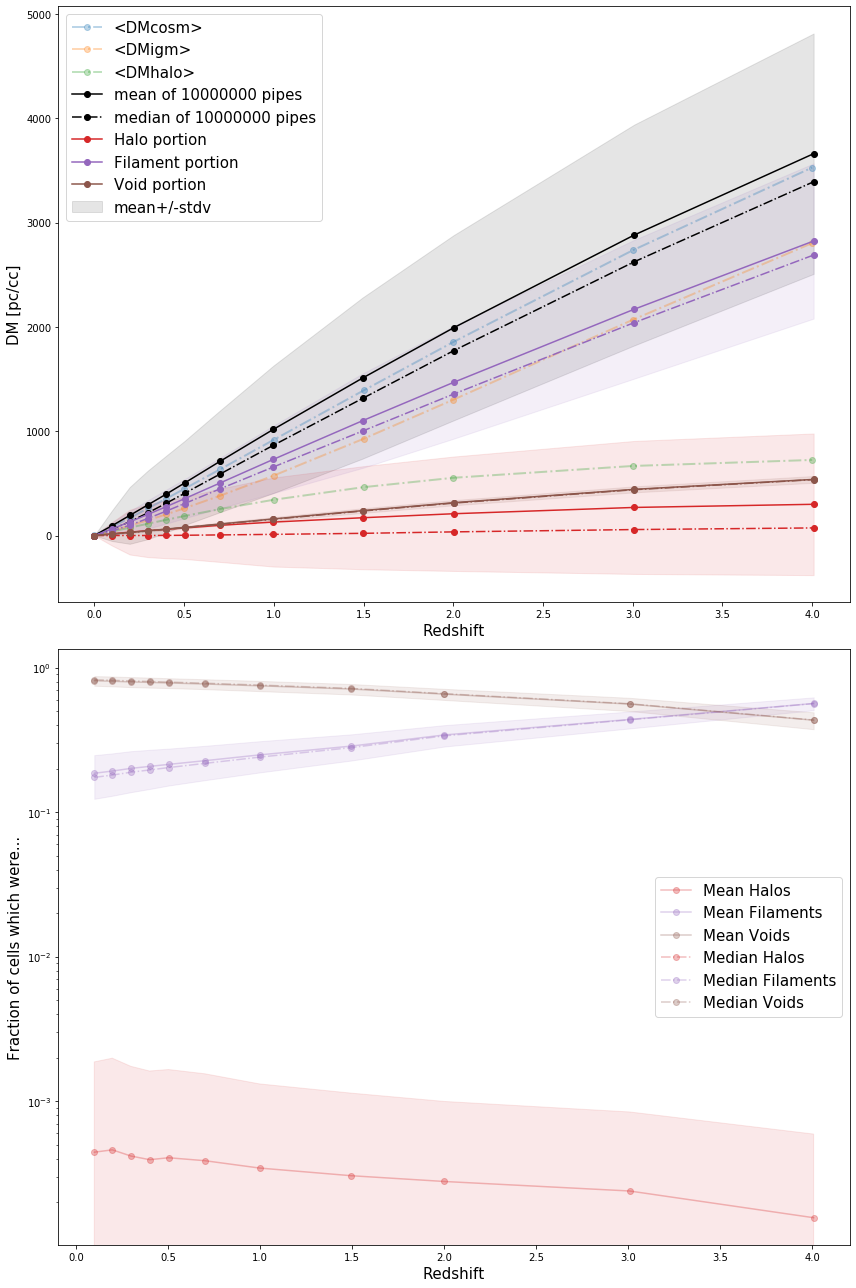

In [14]:
fig = plt.figure(figsize=(12,18))
ax = fig.add_subplot(211)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax.plot(snap_z_list,mean_cDM_arr,marker='o',color='k',alpha=1,ls='-',label='mean of {0} pipes'.format(cDM_arr.shape[1]))
ax.plot(snap_z_list,medi_cDM_arr,marker='o',color='k',alpha=1,ls='-.',label='median of {0} pipes'.format(cDM_arr.shape[1]))
ax.fill_between(snap_z_list,mean_cDM_arr+stdv_cDM_arr,mean_cDM_arr-stdv_cDM_arr,alpha=0.1,color='k',label='mean+/-stdv')

ax.plot(snap_z_list,mean_Hal_cDM_arr,marker='o',color='C3',alpha=1,ls='-',label='Halo portion')
ax.plot(snap_z_list,medi_Hal_cDM_arr,marker='o',color='C3',alpha=1,ls='-.')
ax.fill_between(snap_z_list,mean_Hal_cDM_arr+stdv_Hal_cDM_arr,mean_Hal_cDM_arr-stdv_Hal_cDM_arr,alpha=0.1,color='C3')

ax.plot(snap_z_list,mean_Fil_cDM_arr,marker='o',color='C4',alpha=1,ls='-',label='Filament portion')
ax.plot(snap_z_list,medi_Fil_cDM_arr,marker='o',color='C4',alpha=1,ls='-.')
ax.fill_between(snap_z_list,mean_Fil_cDM_arr+stdv_Fil_cDM_arr,mean_Fil_cDM_arr-stdv_Fil_cDM_arr,alpha=0.1,color='C4')

ax.plot(snap_z_list,mean_Voi_cDM_arr,marker='o',color='C5',alpha=1,ls='-',label='Void portion')
ax.plot(snap_z_list,medi_Voi_cDM_arr,marker='o',color='C5',alpha=1,ls='-.')
ax.fill_between(snap_z_list,mean_Voi_cDM_arr+stdv_Voi_cDM_arr,mean_Voi_cDM_arr-stdv_Voi_cDM_arr,alpha=0.1,color='C5')


plt.legend(fontsize=15)


ax2 = fig.add_subplot(212)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('Fraction of cells which were...',fontsize=15)
ax2.set_yscale('log')

ax2.plot(snap_z_list[1:],mean_frac_Hal_arr[1:],marker='o',alpha=0.3,color='C3',label='Mean Halos')
ax2.plot(snap_z_list[1:],mean_frac_Fil_arr[1:],marker='o',alpha=0.3,color='C4',label='Mean Filaments')
ax2.plot(snap_z_list[1:],mean_frac_Voi_arr[1:],marker='o',alpha=0.3,color='C5',label='Mean Voids')

ax2.plot(snap_z_list[1:],medi_frac_Hal_arr[1:],ls='-.',marker='o',alpha=0.3,color='C3',label='Median Halos')
ax2.plot(snap_z_list[1:],medi_frac_Fil_arr[1:],ls='-.',marker='o',alpha=0.3,color='C4',label='Median Filaments')
ax2.plot(snap_z_list[1:],medi_frac_Voi_arr[1:],ls='-.',marker='o',alpha=0.3,color='C5',label='Median Voids')

ax2.fill_between(snap_z_list[1:],mean_frac_Hal_arr[1:]+stdv_frac_Hal_arr[1:],mean_frac_Hal_arr[1:]-stdv_frac_Hal_arr[1:],alpha=0.1,color='C3')
ax2.fill_between(snap_z_list[1:],mean_frac_Fil_arr[1:]+stdv_frac_Fil_arr[1:],mean_frac_Fil_arr[1:]-stdv_frac_Fil_arr[1:],alpha=0.1,color='C4')
ax2.fill_between(snap_z_list[1:],mean_frac_Voi_arr[1:]+stdv_frac_Voi_arr[1:],mean_frac_Voi_arr[1:]-stdv_frac_Voi_arr[1:],alpha=0.1,color='C5')


plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics.png'.format(sim_to_load),format='png')
plt.show()

# Plot cumulative DM fraction a bit like in the Aghanim presentation

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[   0.           94.54187398  192.25471438  292.87342509  396.15835483
  503.2871693   710.71770234 1017.12728559 1510.10490209 1991.45147051
 2880.54833921 3660.4965925 ] pc / cm3


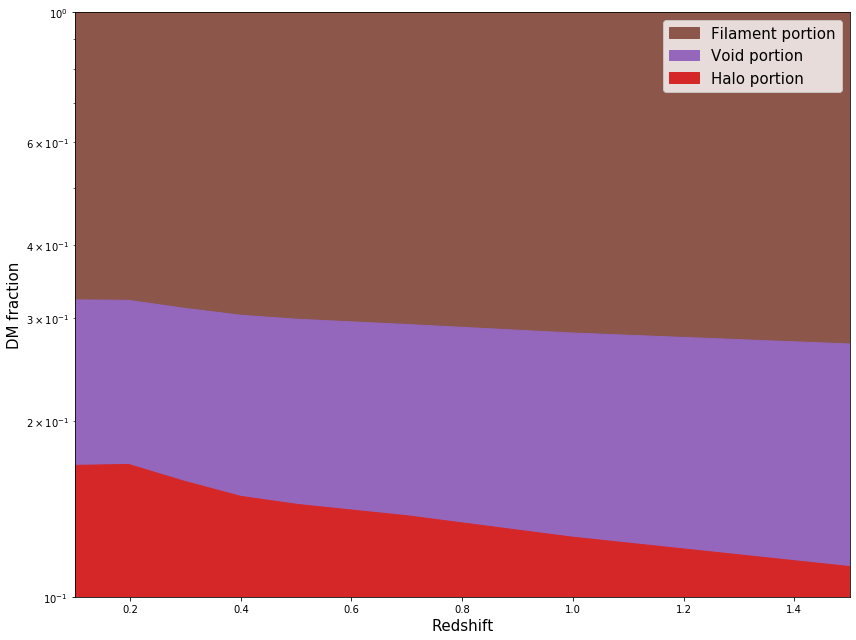

In [15]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM fraction',fontsize=15)
ax.set_yscale('log')
ax.set_xlim([0.1,1.5])
ax.set_ylim([1e-1,1.])


ax.fill_between(snap_z_list,((mean_Hal_cDM_arr+mean_Voi_cDM_arr+mean_Fil_cDM_arr)/mean_cDM_arr[:]),color='C5',alpha=1,ls='-',label='Filament portion')
ax.fill_between(snap_z_list,((mean_Hal_cDM_arr+mean_Voi_cDM_arr)/mean_cDM_arr[:]),color='C4',alpha=1,ls='-',label='Void portion')
ax.fill_between(snap_z_list,(mean_Hal_cDM_arr)/mean_cDM_arr[:],color='C3',alpha=1,ls='-',label='Halo portion')


plt.legend(fontsize=15)

print(mean_Voi_cDM_arr+mean_Fil_cDM_arr+mean_Hal_cDM_arr)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics_2.png'.format(sim_to_load),format='png')
plt.show()

# Histograms of results 

In [16]:
#method for histogramming over one axis from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy

def hist_1d(data,bins=np.linspace(0,5000,100)):
    """
    histograms data along one axis
    adapted from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy
    
    INPUTS:
    
    data : [arr]  array of data to histogram
    """
    
    return np.histogram(data,bins=bins,density=True)[0]

######################
#do the histogramming#
######################

#total
#bin_edges = np.linspace(0,5000,500)
bin_edges = np.logspace(0,4,num=150)

counts = np.apply_along_axis(hist_1d, 1, cDM_arr.value,bin_edges)

Hal_counts = np.apply_along_axis(hist_1d, 1, Hal_cDM_arr.value,bin_edges)
Fil_counts = np.apply_along_axis(hist_1d, 1, Fil_cDM_arr.value,bin_edges)
Voi_counts = np.apply_along_axis(hist_1d, 1, Voi_cDM_arr.value,bin_edges)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [17]:
print(counts.shape)
print(bin_edges.shape)

(12, 149)
(150,)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986


No handles with labels found to put in legend.
No handles with labels found to put in legend.


3 0.2977176845174465
4 0.3999269646135635


No handles with labels found to put in legend.
No handles with labels found to put in legend.


5 0.5030475232448832
6 0.7001063537185233


No handles with labels found to put in legend.


7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986


No handles with labels found to put in legend.
No handles with labels found to put in legend.


3 0.2977176845174465
4 0.3999269646135635


No handles with labels found to put in legend.


5 0.5030475232448832


No handles with labels found to put in legend.
No handles with labels found to put in legend.


6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986


No handles with labels found to put in legend.


3 0.2977176845174465


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233


No handles with labels found to put in legend.


7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233


No handles with labels found to put in legend.


7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676


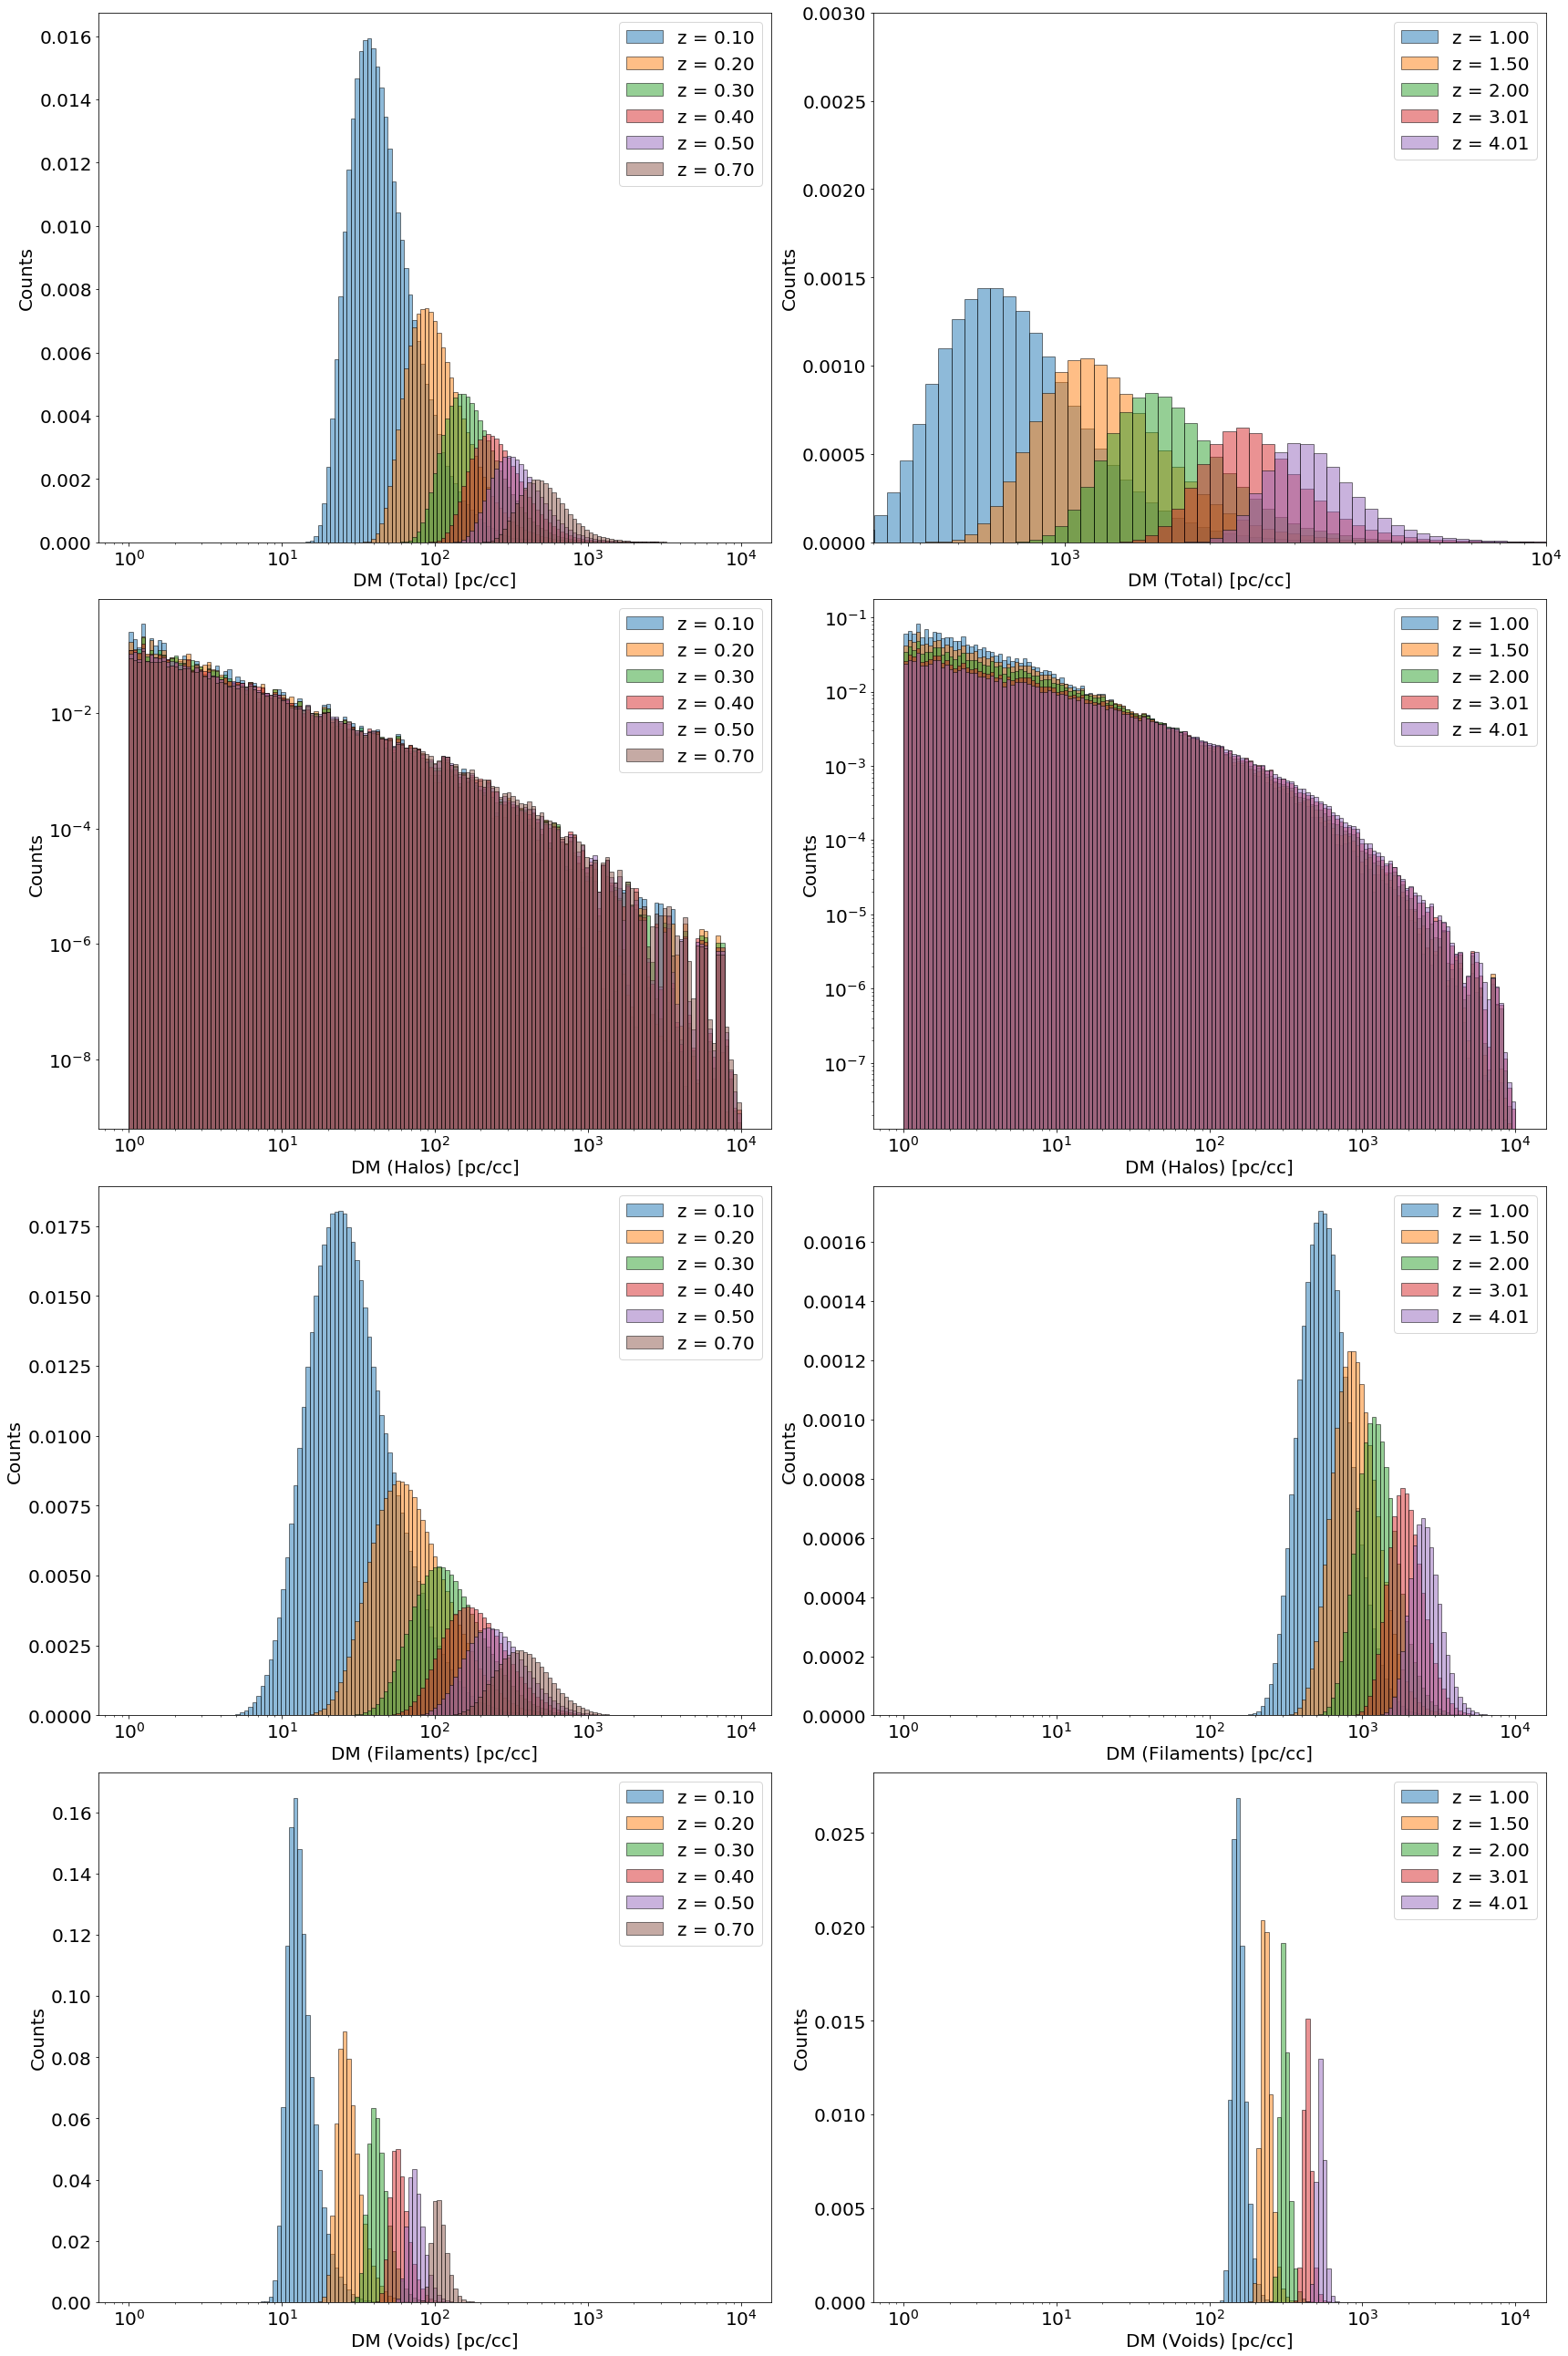

In [18]:
#histogram method from: https://stackoverflow.com/questions/64616617/matplotlib-plot-histogram-given-pre-computed-counts-and-bins

fig = plt.figure(figsize=(24,36))
ax1 = fig.add_subplot(421)
ax1.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(422)
ax2.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)
    
ax3 = fig.add_subplot(423)
ax3.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax3.set_ylabel('Counts',fontsize=20)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

ax4 = fig.add_subplot(424)
ax4.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax4.set_ylabel('Counts',fontsize=20)
ax4.set_xscale('log')
ax4.set_yscale('log')
#ax4.set_ylim([0,0.003])
#ax4.set_xlim([4e2,1e4])
ax4.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax3.bar(x=bin_edges[:-1], height=Hal_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax4.bar(x=bin_edges[:-1], height=Hal_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax3.legend(fontsize=20)
    ax4.legend(fontsize=20)
    
ax5 = fig.add_subplot(425)
ax5.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax5.set_ylabel('Counts',fontsize=20)
ax5.set_xscale('log')
#ax5.set_yscale('log')
ax5.tick_params(axis='x', labelsize=20)
ax5.tick_params(axis='y', labelsize=20)

ax6 = fig.add_subplot(426)
ax6.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax6.set_ylabel('Counts',fontsize=20)
ax6.set_xscale('log')
#ax6.set_yscale('log')
#ax6.set_ylim([0,0.003])
#ax6.set_xlim([4e2,1e4])
ax6.tick_params(axis='x', labelsize=20)
ax6.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax5.bar(x=bin_edges[:-1], height=Fil_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax6.bar(x=bin_edges[:-1], height=Fil_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax5.legend(fontsize=20)
    ax6.legend(fontsize=20)

ax7 = fig.add_subplot(427)
ax7.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax7.set_ylabel('Counts',fontsize=20)
ax7.set_xscale('log')
#ax7.set_yscale('log')
ax7.tick_params(axis='x', labelsize=20)
ax7.tick_params(axis='y', labelsize=20)

ax8 = fig.add_subplot(428)
ax8.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax8.set_ylabel('Counts',fontsize=20)
ax8.set_xscale('log')
#ax8.set_yscale('log')
#ax8.set_ylim([0,0.003])
#ax8.set_xlim([4e2,1e4])
ax8.tick_params(axis='x', labelsize=20)
ax8.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax7.bar(x=bin_edges[:-1], height=Voi_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax8.bar(x=bin_edges[:-1], height=Voi_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax7.legend(fontsize=20)
    ax8.legend(fontsize=20)

plt.tight_layout()
plt.savefig('LSS_Analysis_Hists_{0}.png'.format(sim_to_load),format='png')
plt.show()

# Plot the fits from Zhang+20

12
[0.1 0.2 0.3 0.4 0.5 0.7 1.  1.5 2.  3. ]
my data shape:(11, 10000)
macquart data shape:  (11, 10000)
A shape: (11,)
sigma DM shape: (11,)
C0 shape: (11,)


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/raven/u/cwalker/virtual

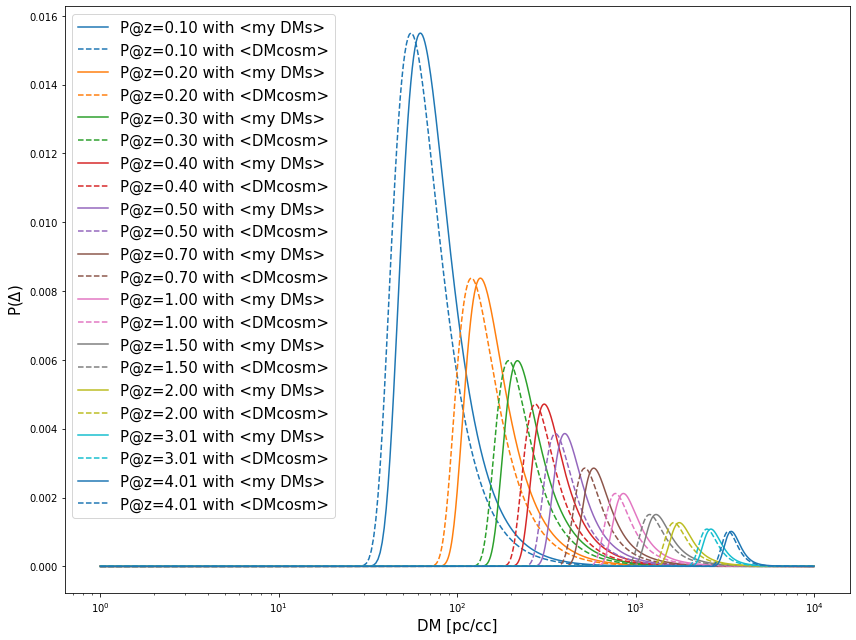

In [19]:
#print(snap_z_list[1:])
#print(np.linspace(0.01,10000))
#print(mean_cDM_arr)
print(len(cosm_theory_2))
print(np.array(theory_z_2)[1:-1])

xarr = np.linspace(0,10000,10000)

#I was unsure what <DMIGM> should go into the data so I did two tests below:
#Test 1: <DMIGM> is the mean of my DM IGM values
Delta_mydata = np.array([xarr/i for i in mean_cDM_arr[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the mean of my data
#Test 2: <DMIGM> is the value from the macquart relation (i.e. <DMcosm)
Delta_macq = np.array([xarr/i for i in np.array(cosm_theory_2)[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the macquart relation

A = np.array([0.04721,
              0.005693,
              0.003584,
              0.002876,
              0.002423,
              0.001880,
              0.001456,
              0.001098,
              0.0009672,
              0.0008968,
              0.0008826]) #from Zhang+20 table 1
alpha=3
beta=3
C0 = np.array([-13.17,
               -1.008,
               0.596,
               1.010,
               1.127,
               1.170,
               1.189,
               1.163,
               1.162,
               1.119,
               1.092]) #from Zhang+20 table 1

sigmaDM = np.array([2.554,
                    1.118,
                    0.7043,
                    0.5158,
                    0.4306,
                    0.3595,
                    0.3044,
                    0.2609,
                    0.2160,
                    0.1566,
                    0.1233]) #from Zhang+20 table 1

print('my data shape:{0}'.format(Delta_mydata.shape))
print('macquart data shape:  {0}'.format(Delta_macq.shape))
print('A shape: {0}'.format(A.shape))
print('sigma DM shape: {0}'.format(sigmaDM.shape))
print('C0 shape: {0}'.format(C0.shape))

#create the P curves for each Delta
P_mydata=(A[:,None]*(Delta_mydata)**(-1*beta))*np.exp(-1*((((Delta_mydata**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))
P_macq=(A[:,None]*(Delta_macq)**(-1*beta))*np.exp(-1*((((Delta_macq**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))

#plot to test
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('DM [pc/cc]',fontsize=15)
ax.set_ylabel('P($\Delta$)',fontsize=15)
ax.set_xscale('log')
for i in range(P_mydata.shape[0]):
    ax.plot(xarr,P_mydata[i],color='C{0}'.format(i),label='P@z={0:.2f} with <my DMs>'.format(snap_z_list[1:][i]))
    ax.plot(xarr,P_macq[i],ls='--',color='C{0}'.format(i),label='P@z={0:.2f} with <DMcosm>'.format(snap_z_list[1:][i]))


plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Zhang_Fits.png'.format(sim_to_load),format='png')
plt.show()
#print(Delta)

Result: Unsure which mean to use. This should be discussed with Laura as our values are actually different to Zhangs, and so these curves might also differ...

# Overplot the fits on the histograms

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233


No handles with labels found to put in legend.


7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676


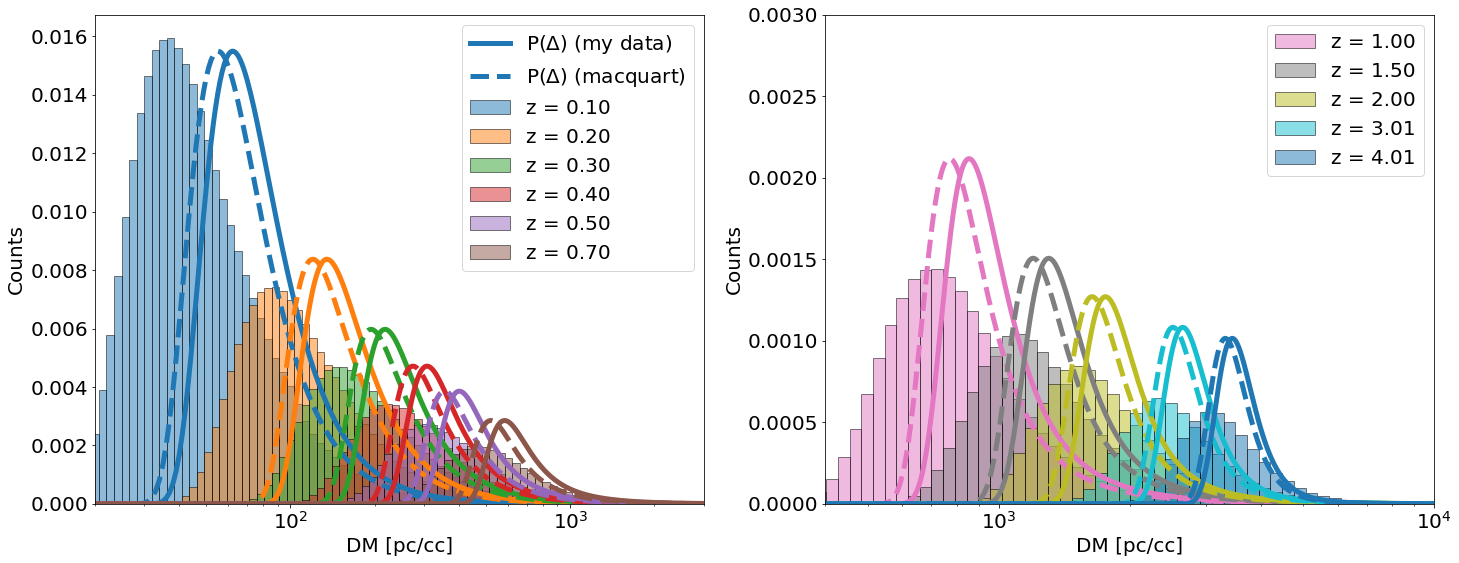

In [20]:
fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.set_xlim([2e1,3e3])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(122)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata[i-1],color='C{0}'.format(i-1),lw=5,label='P($\Delta$) (my data)')
        ax1.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5,label='P($\Delta$) (macquart)')
        
    elif i<7:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata[i-1],color='C{0}'.format(i-1),lw=5)
        ax1.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5)

        
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax2.plot(xarr,P_mydata[i-1],color='C{0}'.format(i-1),lw=5)
        ax2.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5)

        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)

plt.tight_layout
plt.savefig('{0}_Zhang_Fit_Data_Comparisons.png'.format(sim_to_load),format='png')
plt.show()
